# XGBoost 

### Data Import 

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [12]:
def select_device(requested_device=None):
    """
    Selects the most appropriate device available for computations.
    If a device is specified, it checks if that device is available and uses it.
    If no device is specified, it defaults to CUDA if available, then MPS, and finally CPU.

    Parameters:
    - requested_device (str, optional): The requested device as a string (e.g., 'cuda', 'mps', 'cpu').

    Returns:
    - torch.device: The selected PyTorch device.
    - str: Description of the selected device.
    """
    if requested_device:
        # User has requested a specific device
        if requested_device == 'cuda' and torch.cuda.is_available():
            return torch.device('cuda'), "NVIDIA GPU"
        elif requested_device == 'mps' and torch.backends.mps.is_available():
            return torch.device('mps'), "Apple Silicon GPU"
        elif requested_device == 'cpu':
            return torch.device('cpu'), "CPU"
        else:
            raise ValueError(f"Requested device '{requested_device}' is not available or not recognized.")
    
    # Default selection logic if no device is specified
    if torch.cuda.is_available():
        return torch.device("cuda"), "NVIDIA GPU"
    elif torch.backends.mps.is_available():
        return torch.device("mps"), "Apple Silicon GPU"
    else:
        return torch.device("cpu"), "CPU"

# Select the best available device
device, device_name = select_device('mps') 
print(f"Using {device_name} for computation.")


Using Apple Silicon GPU for computation.


In [13]:
# Import the data 
def load_and_prepare_data(file_path):
    """
    Load energy prices data from a CSV file, ensure chronological order, and convert 'Date' to datetime.
    """
    df = pd.read_csv(file_path, parse_dates=['date'])
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    df.set_index('date', inplace=True)
    df = pd.DataFrame(df)
    return df

In [14]:
df = load_and_prepare_data('../../data/Final_data/final_data.csv')

In [15]:
df

,Day_ahead_price,BEV_vehicles,Biomass (GWh),Hard Coal (GWh),Hydro (GWh),Lignite (GWh),Natural Gas (GWh),Nuclear (GWh),Oil_price (EUR),Other (GWh),Pumped storage generation (GWh),Solar (GWh),Solar_radiation,TTF_gas_price (EUR/MWh),Temperature,Wind offshore (GWh),Wind onshore (GWh),Wind_speed,net_total_export_import (GWh)
date,,,,,,,,,,,,,,,,,,,
2012-01-01,18.1896,6,98.605,108.454,51.011,325.337,188.811,250.979,98.99,54.040,19.314,6.263,14.75,21.1000,8.39,3.404,235.467,4.95,54.662
2012-01-02,33.8188,6,98.605,222.656,51.862,343.168,229.293,258.671,99.39,54.166,28.892,6.312,15.12,20.0000,7.41,3.350,231.772,5.00,-64.477
2012-01-03,35.0263,6,98.605,162.204,48.851,336.773,241.297,271.495,99.79,53.518,21.072,24.226,31.88,20.9000,5.23,7.292,504.484,7.77,-35.078
2012-01-04,32.1633,6,98.605,189.633,47.101,323.976,252.289,270.613,102.48,52.194,28.300,14.157,25.21,21.4000,4.78,7.828,541.528,8.04,22.924
2012-01-05,20.3500,6,98.605,175.733,45.854,327.502,259.018,287.555,103.24,52.179,31.887,4.728,13.46,21.3000,4.23,8.280,572.819,9.98,35.618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-25,61.0938,947,123.683,48.501,58.671,193.697,255.124,0.000,74.73,60.627,13.565,169.216,97.58,23.7625,4.52,29.879,278.787,3.43,-36.930
2024-02-26,66.2683,947,124.810,69.146,58.444,281.177,289.764,0.000,74.60,59.810,12.231,110.504,73.25,23.9000,4.96,62.336,239.555,3.12,-198.686
2024-02-27,73.8362,947,124.989,103.379,59.181,351.355,354.042,0.000,75.61,67.170,23.753,85.584,58.12,24.8300,4.53,16.951,131.761,3.11,-209.332


# XGBoost Model implementation

In [22]:
from xgboost import plot_importance, plot_tree

### 1. Introduce lagged price


In [16]:
df['lagged_price'] = df['Day_ahead_price'].shift(1)
df.dropna(inplace=True)  # Remove rows with NaN values that may have been introduced by shifting


### 2. Train/Test Split

In [17]:
X = df.drop('Day_ahead_price', axis=1)
y = df['Day_ahead_price']

# Assuming you're using the last 20% of the data as test set
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


### 3. Scale the input data


In [35]:
scaler = MinMaxScaler()
# Scale the test and train data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### 3. Model training

In [36]:
from sklearn.model_selection import GridSearchCV
xgb1 = xgb.XGBRegressor()
parameters = { #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100,500, 1000],
             'n_jobs' : [-1]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(X_train_scaled,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/Users/skyfano/Documents/Masterarbeit/Prediction_of_energy_prices/master_thesis/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:47:07] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/skyfano/Documents/Masterarbeit/Prediction_of_energy_prices/master_thesis/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:47:07] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/skyfano/Documents/Masterarbeit/Prediction_of_energy_prices/master_thesis/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:47:07] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244

0.6395453751699259
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'n_jobs': -1, 'objective': 'reg:squarederror', 'silent': 1, 'subsample': 0.7}


In [37]:
xgbbest = xgb.XGBRegressor(objective='reg:squarederror', min_child_weight = 4, max_depth = 5, n_estimators = 500, learning_rate=0.03, colsample_bytree =0.7, n_jobs = -1, silent = 1 , subsample = 0.7)
xgbbest.fit(X_train_scaled,
         y_train)

/Users/skyfano/Documents/Masterarbeit/Prediction_of_energy_prices/master_thesis/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:49:00] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [38]:
predictionsxgb = xgbbest.predict(X_test_scaled)

In [39]:
predictionsxgb=pd.DataFrame(predictionsxgb)
predictionsxgb.reset_index(drop=True, inplace=True)
predictionsxgb.index=X_test.index
predictionsxgb.rename(columns={0:'Predictions Day_Ahead_Price'}, inplace=True)

In [40]:
predictionsxgb

,Predictions Day_Ahead_Price
date,
2021-09-25,122.404602
2021-09-26,117.914955
2021-09-27,145.538788
2021-09-28,141.266266
2021-09-29,124.594147
...,...
2024-02-25,56.127148
2024-02-26,61.804005
2024-02-27,68.339371


RMSE: 115.48938963232239


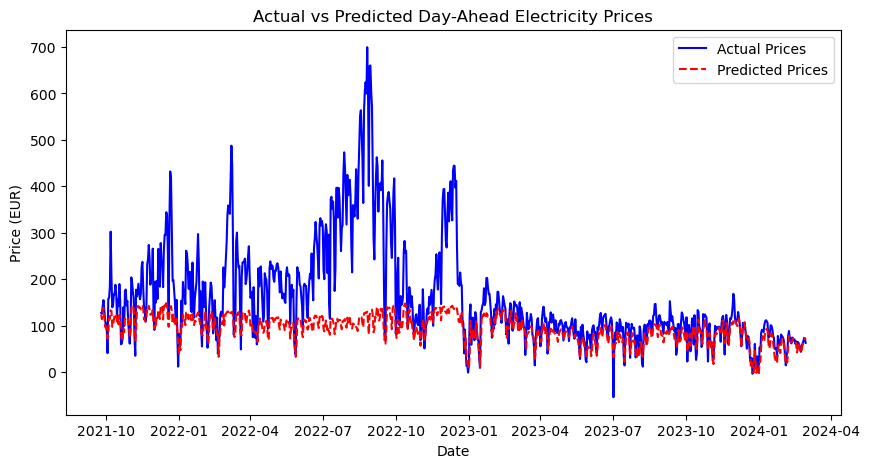

In [34]:
#y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictionsxgb))
print(f"RMSE: {rmse}")

# Plotting actual vs predicted prices
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')
plt.plot(y_test.index, predictionsxgb, label='Predicted Prices', color='red', linestyle='--')
plt.title('Actual vs Predicted Day-Ahead Electricity Prices')
plt.xlabel('Date')
plt.ylabel('Price (EUR)')
plt.legend()
plt.show()


In [ ]:
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05)
model.fit(X_train, y_train, 
          eval_set=[(X_test, y_test)],
          early_stopping_rounds=50,
          verbose=True)  # Set verbose to True if you want to see the training progress


RMSE: 114.14707131304651


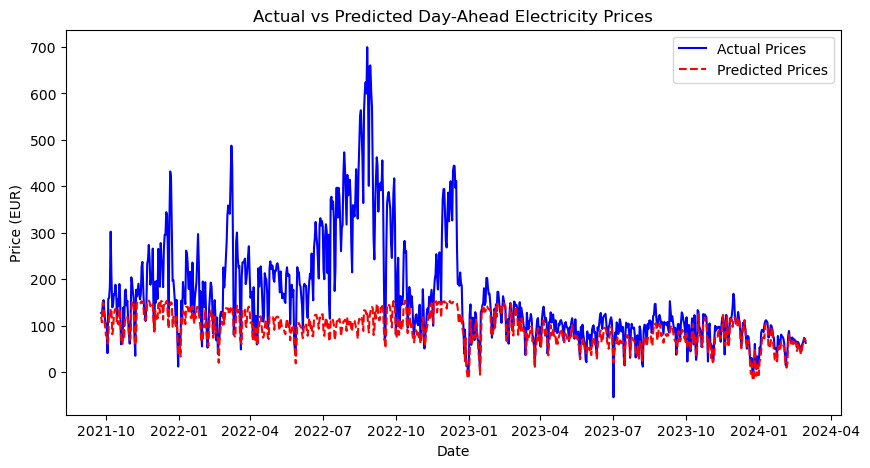

In [19]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

# Plotting actual vs predicted prices
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Prices', color='red', linestyle='--')
plt.title('Actual vs Predicted Day-Ahead Electricity Prices')
plt.xlabel('Date')
plt.ylabel('Price (EUR)')
plt.legend()
plt.show()


In [20]:
# Predicting the next day (or the days you need predictions for)
next_day_features = df.iloc[-1].drop('Day_ahead_price')  # Assuming the next day's features are available
next_day_price = model.predict(np.array(next_day_features).reshape(1, -1))
print(f"Predicted Day-Ahead Price for the next day: {next_day_price[0]}")


Predicted Day-Ahead Price for the next day: 66.790771484375
